In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [118]:
df =pd.read_csv(r"C:\Users\panch\Desktop\Python EDA\PJME_hourly.csv")
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)
df1=df.copy()

<AxesSubplot:title={'center':'PJME Energy use in MW'}, xlabel='Datetime'>

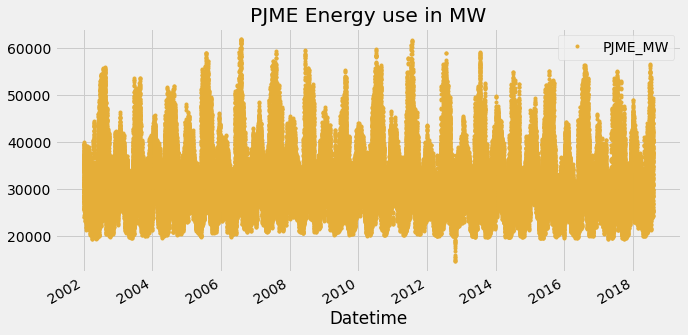

In [119]:
df.plot(style='.',figsize=(10,5),color=color_pal[2],title='PJME Energy use in MW')

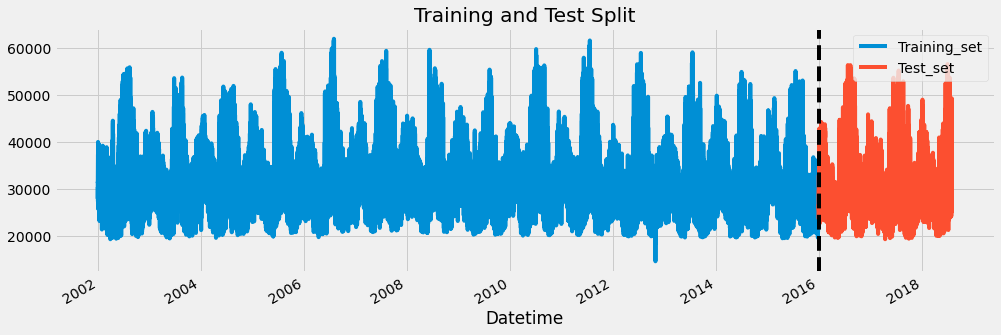

In [120]:
train =df.loc[df.index<'01-01-2016']
test= df.loc[df.index>='01-01-2016']
fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training_Set',title='Training and Test Split')
test.plot(ax=ax,label='Test_set')
ax.axvline('01-01-2016',color='black',ls='--')
ax.legend(['Training_set','Test_set'])
plt.show()

<AxesSubplot:xlabel='Datetime'>

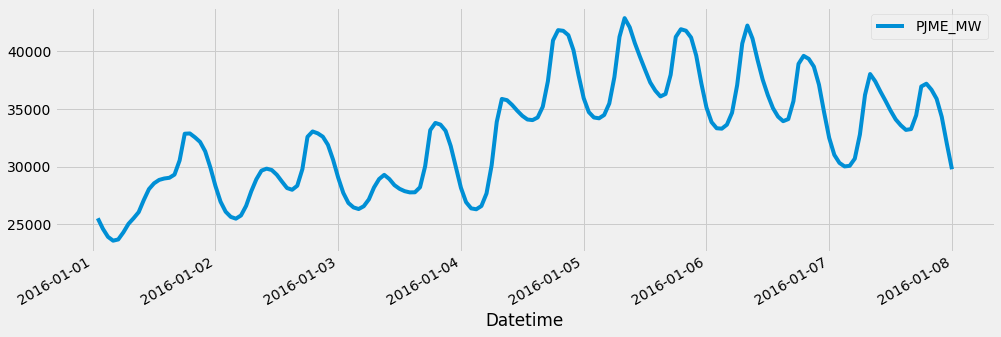

In [121]:
week_data=df.loc[(df.index>'01-01-2016') & (df.index<='01-08-2016')]
week_data.plot(figsize=(15,5))

In [122]:
def time_features(df):
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.day_of_week
    df['month']=df.index.month
    df['quarter']=df.index.quarter
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df


In [123]:
df=time_features(df)
df

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,4,2002,365
2002-12-31 02:00:00,25147.0,2,1,12,4,2002,365
2002-12-31 03:00:00,24574.0,3,1,12,4,2002,365
2002-12-31 04:00:00,24393.0,4,1,12,4,2002,365
2002-12-31 05:00:00,24860.0,5,1,12,4,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


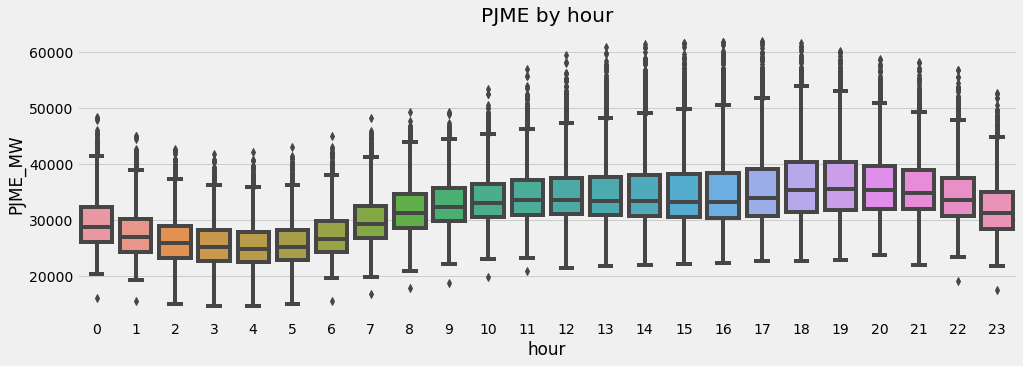

In [124]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('PJME by hour')
plt.show()

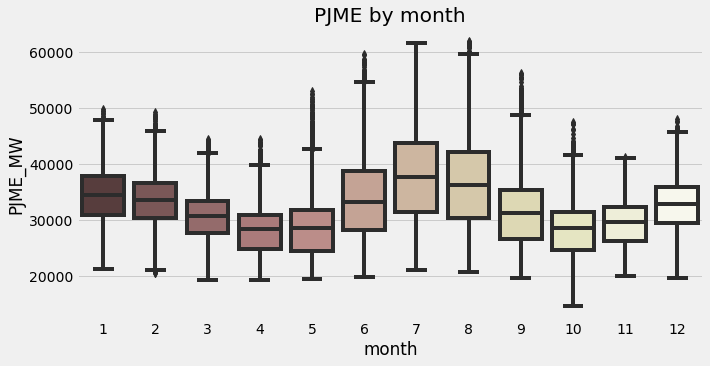

In [125]:
fig,ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=df,x='month',y='PJME_MW',palette='pink')
ax.set_title('PJME by month')
plt.show()

In [126]:
train=time_features(train)
test=time_features(test)

In [127]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear'],
      dtype='object')

In [128]:
features=['hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear']
target=['PJME_MW']

In [129]:
X_train=train[features]
y_train=train[target]
X_test=test[features]
y_test=test[target]

In [130]:
reg=xgb.XGBRegressor(n_estimators=900,early_stopping_rounds=50,learning_rate=0.001)

reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:6459.98644	validation_1-rmse:6471.21608
[100]	validation_0-rmse:6038.07009	validation_1-rmse:6102.12713
[200]	validation_0-rmse:5666.29717	validation_1-rmse:5784.28856
[300]	validation_0-rmse:5337.88030	validation_1-rmse:5507.21196
[400]	validation_0-rmse:5050.90182	validation_1-rmse:5268.01939
[500]	validation_0-rmse:4799.67758	validation_1-rmse:5063.96714
[600]	validation_0-rmse:4578.99691	validation_1-rmse:4886.54193
[700]	validation_0-rmse:4386.62924	validation_1-rmse:4735.70665
[800]	validation_0-rmse:4218.42871	validation_1-rmse:4607.99581
[899]	validation_0-rmse:4073.73774	validation_1-rmse:4500.99927


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [131]:
feature_imp=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])

<AxesSubplot:title={'center':'Feature Importance'}>

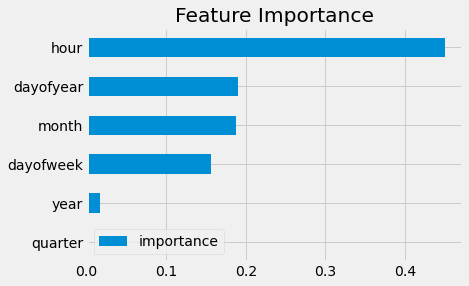

In [132]:
feature_imp.sort_values('importance').plot(kind='barh',title='Feature Importance')

In [133]:
test['prediction']=reg.predict(X_test)
df=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

Text(0.5, 1.0, 'raw data vs new predictions')

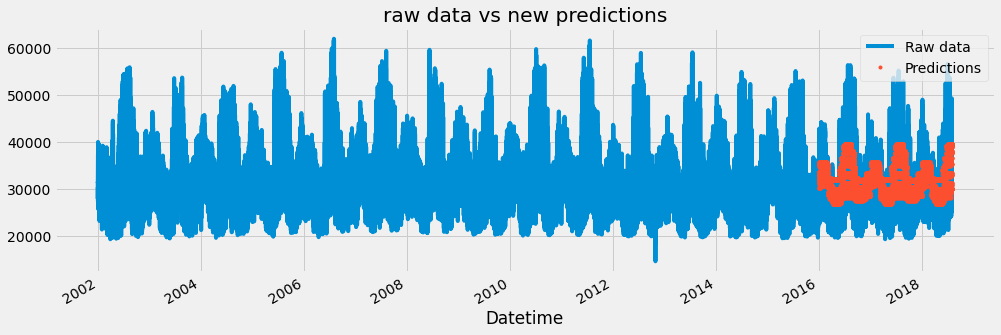

In [134]:
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Raw data','Predictions'])
ax.set_title('raw data vs new predictions')

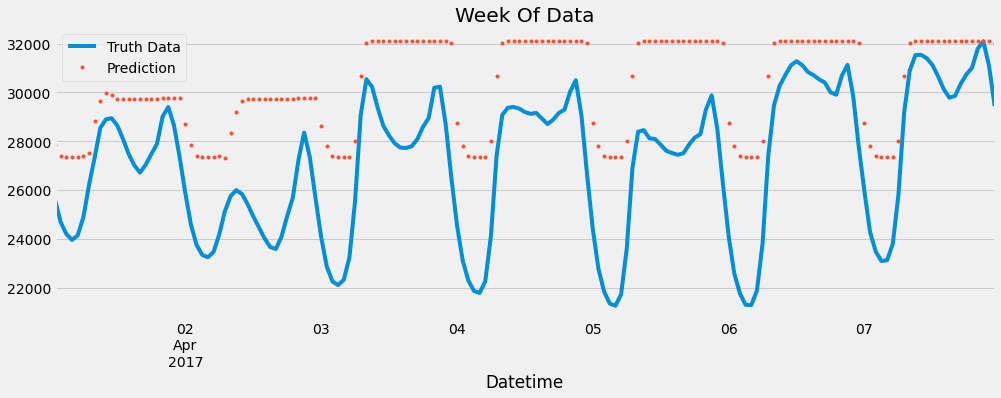

In [135]:
ax = df.loc[(df.index > '04-01-2017') & (df.index < '04-08-2017')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2017') & (df.index < '04-08-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [136]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4501.00


<AxesSubplot:ylabel='Frequency'>

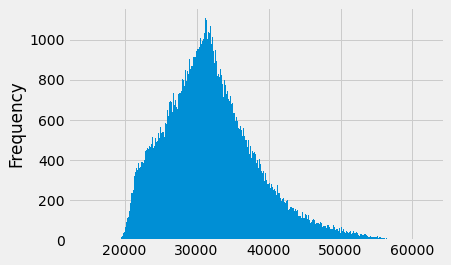

In [137]:

df1['PJME_MW'].plot(kind='hist',bins=500)

<AxesSubplot:xlabel='Datetime'>

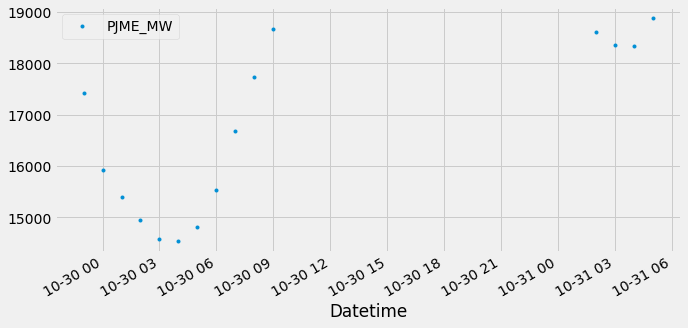

In [140]:
df1.query('PJME_MW < 19000').plot(figsize=(10,5),style='.')

In [145]:
from sklearn.model_selection import TimeSeriesSplit

In [146]:
tss=TimeSeriesSplit(n_splits=5,test_size=24*365*1, gap=24)
df1=df1.sort_index()

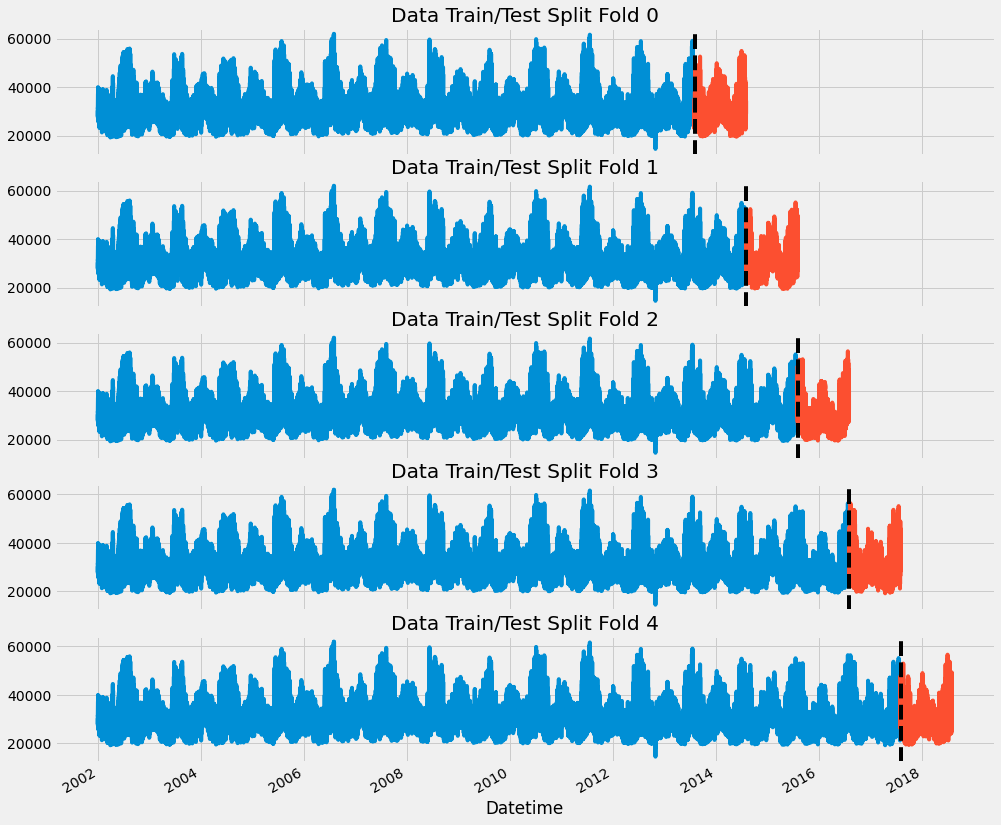

In [147]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [148]:
df1=time_features(df1)

In [151]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [153]:
df1=add_lags(df1)
df1

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,8,3,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,8,3,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,8,3,2018,214,39525.0,38698.0,37330.0


In [155]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df1 = df1.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df1):
    train = df1.iloc[train_idx]
    test = df1.iloc[val_idx]

    train = time_features(train)
    test = time_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992


C:\Users\panch\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[472]	validation_0-rmse:3339.96200	validation_1-rmse:3766.70959
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280


C:\Users\panch\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	validation_1-rmse:3430.10289
[999]	validation_0-rmse:3171.60041	validation_1-rmse:3423.30152
[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137


C:\Users\panch\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.98688	validation_1-rmse:11138.63967
[200]	validation_0-rmse:5752.02891	validation_1-rmse:4816.91019
[300]	validation_0-rmse:3919.15626	validation_1-rmse:3552.07912
[400]	validation_0-rmse:3498.18633	validation_1-rmse:3492.18418
[0]	validation_0-rmse:32527.02577	validation_1-rmse:31475.38351


C:\Users\panch\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.05865	validation_1-rmse:12020.44091
[200]	validation_0-rmse:5737.80165	validation_1-rmse:5797.76066
[300]	validation_0-rmse:3915.35694	validation_1-rmse:4384.39516
[400]	validation_0-rmse:3498.63311	validation_1-rmse:4169.62998
[500]	validation_0-rmse:3383.05051	validation_1-rmse:4111.26353
[550]	validation_0-rmse:3350.27015	validation_1-rmse:4112.59860
[0]	validation_0-rmse:32460.74594	validation_1-rmse:31463.90740


C:\Users\panch\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.47503	validation_1-rmse:11959.11979
[200]	validation_0-rmse:5752.02184	validation_1-rmse:5613.55633
[300]	validation_0-rmse:3951.97347	validation_1-rmse:4156.62286
[400]	validation_0-rmse:3542.75274	validation_1-rmse:4008.30348
[436]	validation_0-rmse:3488.10069	validation_1-rmse:4006.43301


In [157]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3754.6872
Fold scores:[3758.5256000579657, 3423.147857410298, 3476.121686141068, 4111.027693505075, 4004.6130268714915]


In [158]:
df1 = time_features(df1)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df1[FEATURES]
y_all = df1[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32402.66145


C:\Users\panch\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.65728
[200]	validation_0-rmse:5753.26464
[300]	validation_0-rmse:3973.71114
[400]	validation_0-rmse:3574.05442
[499]	validation_0-rmse:3459.67006


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [159]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [161]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df1['isFuture'] = False
df_and_future = pd.concat([df1, future_df])
df_and_future = time_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [162]:
future_w_features = df_and_future.query('isFuture').copy()

In [163]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

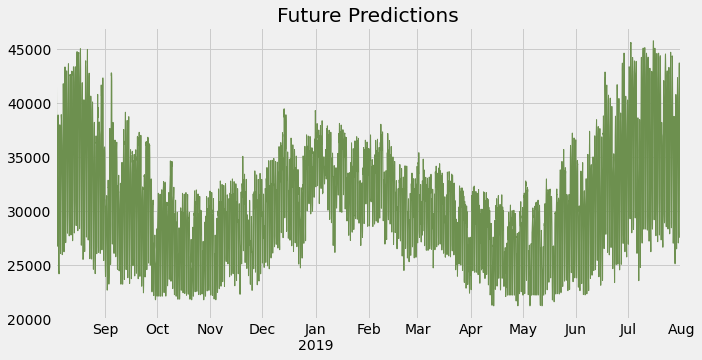

In [167]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [168]:
reg.save_model('model.json')